In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import crystalball

from stripROtools import colors
from stripROtools import GetTransErrs
from stripROtools import Mismeasurment_vs_z
from stripROtools import random_three_vector
from stripROtools import plot_track

In [2]:
# Solid angle range in theta [degrees]
theta_min = 15
theta_max = 30

# dataframe with time offset info used for 3D reconstruction
T_off = pd.read_pickle("./data/time_offset.pk")
T_off

,Name,Mu,Mu_err,Sigma,Sigma_err
0,UH DLC a,-6.684141,0.031719,16.382493,0.024764
1,UH DLC b,-5.208232,0.034228,16.305925,0.026783
2,UH DLC c,6.752723,0.038583,14.113659,0.031446
3,UH DLC d,6.852294,0.058807,14.800689,0.048234
4,UH NoDLC a,5.703480,0.075588,19.574833,0.061573
5,UH NoDLC b,5.473110,0.114114,19.799337,0.092169
6,UH NoDLC c,25.241775,0.189180,18.082547,0.159142
7,UH NoDLC d,20.674842,0.698955,17.886667,0.626167
8,UoS,-11.400385,0.026963,15.290716,0.021079


# Read dE/dx data from SRIM

In [3]:
# Load dEdx data simulated with SRIM
dEdx_data = np.loadtxt("./data/srim_po210_heco2.txt",skiprows=4)

dEdx_data = dEdx_data.T

# convert from angstrom to cm
dEdx_data[0] = dEdx_data[0]*1e-8

#dEdx resolution as seen in dEdx_data[0] 
delta_x = 0.1

# convert to eV/cm
dEdx_data[1] = dEdx_data[1]/1e-8
dEdx_data[2] = dEdx_data[2]/1e-8

dEdx = dEdx_data[1] + dEdx_data[2]




Text(0, 0.5, 'dE/dx [eV/cm] ')

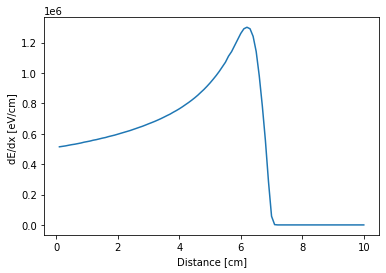

In [4]:
plt.plot(dEdx_data[0],dEdx)
plt.xlabel("Distance [cm]")
plt.ylabel("dE/dx [eV/cm] ")


# Simulate Po210 alpha tracks

In [5]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# Apply diffusion T/F
# Transverse diffusion coefficent from Magboltz [cm/sqrt(cm)]
# W-value as obtained using degrad

def sim_p210(n_sims = 100, theta_min = theta_min, theta_max = theta_max, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2):

    tracks = pd.DataFrame(columns = ['direction', 'start', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max+0.1,0.1)

        # Edges of the length segments we will distribute charge on (all edges are listed)
        L_edges = np.append(L_segments,L_max)

        # Energy deposited in each segment given dEdx (energy in each bin is listed)
        E_segments = dEdx[0:len(L_segments)]*np.diff(L_edges)

        # Compute corresponding number of ionizaed eletrons using energy deposited per segment divided by W-value
        Ne_segments = np.round(E_segments/W).astype("int")

        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        for N,left_edge,right_edge in zip(Ne_segments,Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=N)

            if Diff == False:

                x_vals = Ts*v[0]
                y_vals = Ts*v[1]
                z_vals = DL + Ts*v[2]

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)
            
            elif Diff == True:

                z_vals = DL + Ts*v[2]

                x_vals = Ts*v[0] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                y_vals = Ts*v[1] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                z_vals = z_vals + DLong*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize x position (1 cm random uniform dist)

        tracks = tracks.append({'direction' : v, 'start' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




In [6]:
# Example of track simulation
tracks = sim_p210(n_sims = 100)
tracks.head()

,direction,start,track
0,"[-0.38058527909186224, 0.11251641782776649, -0...","[-0.23482086138719482, -0.15551214866392504, 1.2]","[[-0.24664130810181095, -0.14998332286995764, ..."
1,"[-0.2541985677103682, 0.4280419930817471, -0.8...","[-0.01036704283807166, -0.4956259804815617, 1.2]","[[-0.036218893050143745, -0.45654122984168133,..."
2,"[0.1389971489671187, -0.2956485907690764, -0.9...","[-0.3368008857742555, 0.26296695091498934, 1.2]","[[-0.3152815615827571, 0.26561446803104216, 1...."
3,"[0.17997139143849428, -0.30434898234494484, -0...","[-0.08749264196803985, 0.28638298096026105, 1.2]","[[-0.1131812018732789, 0.2732978442983458, 1.2..."
4,"[-0.23369305548783995, 0.39743508802513544, -0...","[-0.23452452420979375, -0.4604631482678486, 1.2]","[[-0.22409396302279883, -0.4191852258828124, 1..."


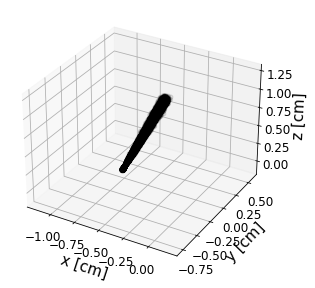

In [7]:
# Plot a Track
index = 0
track = tracks.iloc[index]["track"]
plot_track(track)

# Simulate readout


In [9]:
# the parameters, in order, are:
# peaking time [ns]
# digitization time [ns] 
# pitch of the x strips [um]
# pitch of the y strips [um]
# Threshold of x strips [No. electrons]
# Threshold of y strips [No. electrons]
# Charge sharing [lower strips / upper strips]
# Gain - extrapolating from PHA curve
# drift speed cm/ns
# Include charge integration effect.
# z resolution in cm, must be specified if Charge_integration = False
# Electronic gain in x [mV/fC]
# Electronic gain in y [mV/fC]

def sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = 200, pitch_y = 200,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = 0.62, Gain = 604, v_drift = 0.0008, Charge_integration = True, DL = 1.2, pitch_z = 0.02, G_x = 9.0, G_y = 4.5):

    #convert pitch to cm
    pitch_x = pitch_x * 1e-4
    pitch_y = pitch_y * 1e-4
    
    # Readout is 10 cm x 10 cm
    x_bins = np.arange(-5,5,pitch_x)
    y_bins = np.arange(-5,5,pitch_y)

    # Find strip edges in x and y
    Left_edges_x = x_bins[0:-1]
    Right_edges_x = x_bins[1:]
    Left_edges_y = y_bins[0:-1]
    Right_edges_y = y_bins[1:]


    hits = pd.DataFrame(columns = ['strips_x', 'strips_y', 'times_x', 'times_y','electrons_x','electrons_y'])

    for index, row in tracks.iterrows():

        track = row.track

        x_positions = []
        x_charges = []
        x_times = []
        adcs0 = []
        strips0 = []

        for L_edge,R_edge in zip(Left_edges_x,Right_edges_x):

            # Bin track over specific strip in x
            T_track = track[(track[:,0]> L_edge) &  (track[:,0]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):


                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) *Gain * CS / (CS+1.0)

                    if charge_detected > thres_x:
                        
                        # obtain mean time for the hit
                        x_times += [mean_time]
                        # obtain position of the hit
                        x_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips0 += [np.where(x_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        x_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs0 += [min( charge_detected/6241.5*G_x, 1023.0 ) ]

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,DL+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist *Gain * CS / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_x]
                    charge_detected = charge_detected [charge_detected>thres_x]


                    x_times += list(bin_centers/v_drift)
                    x_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    x_charges += list(charge_detected)

        

        y_positions = []
        y_charges = []
        y_times = []
        adcs1 = []
        strips1 = []

        for L_edge,R_edge in zip(Left_edges_y,Right_edges_y):

            # Bin track over specific strip in x
            T_track = track[(track[:,1]> L_edge) &  (track[:,1]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):

                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) * Gain / (CS+1.0)

                    if charge_detected > thres_y:

                        # obtain mean time for the hit
                        y_times += [mean_time]
                        # obtain position of the hit
                        y_positions += [ (L_edge+R_edge)/2.0 ]
                        # Position expressed consistently with exp digitized data
                        strips1 += [np.where(y_bins == L_edge)[0][0]]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        y_charges += [ charge_detected ]
                        # Charge expressed consistently with exp digitized data
                        adcs1 += [ min( charge_detected/6241.5*G_y, 1023.0 ) ] # The min imposes saturation of ADC scale

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,DL+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist * Gain / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_y]
                    charge_detected = charge_detected [charge_detected>thres_y]


                    y_times += list(bin_centers/v_drift)
                    y_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    y_charges += list(charge_detected)

        hits = hits.append({'strips_x' : np.array(x_positions), 'strips0' : np.array(strips0),  'strips_y' : np.array(y_positions), 'strips1' : np.array(strips1), 'times_x' : np.array(x_times), 'times0' : np.array(x_times), 'times_y' : np.array(y_times), 'times1' : np.array(y_times), 'electrons_x' :  np.array(x_charges), 'adcs0' :  np.array(adcs0), 'electrons_y' : np.array(y_charges), 'adcs1' :  np.array(adcs1) }, ignore_index = True)
        
    return hits


In [10]:
# Example of readout simulation
hits = sim_readout(tracks)
tracks = pd.concat([tracks,hits],axis=1)
tracks.head()


,direction,start,track,strips_x,strips_y,times_x,times_y,electrons_x,electrons_y,adcs0,adcs1,strips0,strips1,times0,times1
0,"[-0.38058527909186224, 0.11251641782776649, -0...","[-0.23482086138719482, -0.15551214866392504, 1.2]","[[-0.24664130810181095, -0.14998332286995764, ...","[-0.7700000000000902, -0.7500000000000906, -0....","[-0.07000000000010509, -0.050000000000105516, ...","[-92.39980339619007, -53.95500376983541, 7.034...","[469.8650233632151, 336.2258237800404, 181.958...","[69348.14814814815, 192556.6913580247, 203421....","[133849.38271604938, 371720.98765432095, 66663...","[99.99732970172766, 277.65925213846384, 293.32...","[96.50279936268882, 268.0035960016734, 480.632...","[211, 212, 213, 214, 215, 216, 217, 218, 219, ...","[246, 247, 248, 249, 250]","[-92.39980339619007, -53.95500376983541, 7.034...","[469.8650233632151, 336.2258237800404, 181.958..."
1,"[-0.2541985677103682, 0.4280419930817471, -0.8...","[-0.01036704283807166, -0.4956259804815617, 1.2]","[[-0.036218893050143745, -0.45654122984168133,...","[-0.3700000000000987, -0.3500000000000991, -0....","[-0.49000000000009614, -0.47000000000009656, -...","[-3.4978697596800643, 54.2469252228037, 140.39...","[1465.4095365222809, 1428.0801987026273, 1379....","[88534.46913580246, 301202.1234567901, 286870....","[165540.74074074073, 224076.54320987652, 24793...","[127.66325758587232, 434.32173533783725, 413.6...","[119.35165157948141, 161.55482567402777, 178.7...","[231, 232, 233, 234, 235, 236, 237, 238, 239, ...","[225, 226, 227, 228, 229, 230, 231, 232, 233, ...","[-3.4978697596800643, 54.2469252228037, 140.39...","[1465.4095365222809, 1428.0801987026273, 1379...."
2,"[0.1389971489671187, -0.2956485907690764, -0.9...","[-0.3368008857742555, 0.26296695091498934, 1.2]","[[-0.3152815615827571, 0.26561446803104216, 1....","[-0.2900000000001004, -0.2700000000001008, -0....","[-0.11000000000010424, -0.09000000000010466, -...","[928.114621158909, 775.5571455483895, 614.9231...","[10.85048906467388, 91.33833682343854, 171.643...","[71428.59259259258, 77669.92592592593, 66111.9...","[406395.06172839506, 398565.4320987654, 396701...","[102.9972495927795, 111.997009265935, 95.33078...","[293.0029284271053, 287.35791787942713, 286.01...","[235, 236, 237, 238, 239, 240, 241, 242]","[244, 245, 246, 247, 248, 249, 250, 251, 252, ...","[928.114621158909, 775.5571455483895, 614.9231...","[10.85048906467388, 91.33833682343854, 171.643..."
3,"[0.17997139143849428, -0.30434898234494484, -0...","[-0.08749264196803985, 0.28638298096026105, 1.2]","[[-0.1131812018732789, 0.2732978442983458, 1.2...","[-0.09000000000010466, -0.050000000000105516, ...","[-0.11000000000010424, -0.09000000000010466, -...","[1365.0914447198004, 1118.3711808033822, 998.0...","[-1.2477423922094424, 56.47999631663997, 133.1...","[59408.246913580246, 63106.81481481481, 66805....","[190893.82716049382, 395582.7160493827, 378804...","[85.66437911114672, 90.99757002857217, 96.3307...","[137.6307333529155, 285.20743767078784, 273.11...","[245, 247, 248, 249, 250, 251, 252, 253, 254, ...","[244, 245, 246, 247, 248, 249, 250, 251, 252, ...","[1365.0914447198004, 1118.3711808033822, 998.0...","[-1.2477423922094424, 56.47999631663997, 133.1..."
4,"[-0.23369305548783995, 0.39743508802513544, -0...","[-0.23452452420979375, -0.4604631482678486, 1.2]","[[-0.22409396302279883, -0.4191852258828124, 1...","[-0.5500000000000949, -0.5300000000000953, -0....","[-0.450000000000097, -0.4300000000000974, -0.4...","[4.524570130528332, 100.02927372564324, 194.26...","[1452.952946829838, 1406.4110599443272, 1355.8...","[316689.87654320983, 315765.23456790124, 31877...","[190148.14814814815, 234143.2098765432, 258004...","[456.65447230455635, 455.3211745752001, 459.65...","[137.0931133007557, 168.81269637818545, 186.01...","[222, 223, 224, 225, 226, 227, 228, 229, 230, ...","[227, 228, 229, 230, 231, 232, 233, 234, 235, ...","[4.524570130528332, 100.02927372564324, 194.26...","[1452.952946829838, 1406.4110599443272, 1355.8..."


# Perform 3D Reconstruction

[   3.12066293   88.12631253  175.12425674  262.26696907  348.41001478
  433.5681401   506.01934369  600.91081056  681.29293564  764.61189911
  802.9264585   939.76824039 1014.66811853 1094.38951963 1179.49355246
 1261.3690118  1328.00314213 1408.92919192]


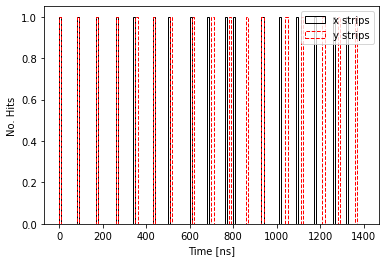

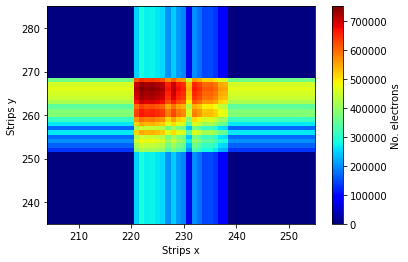

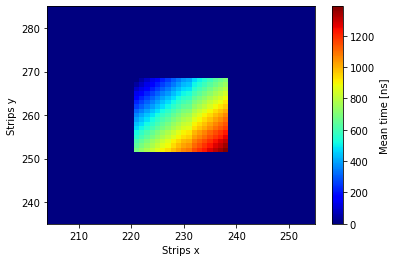

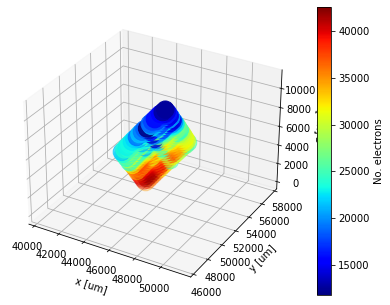

/Users/majdghrear/Lab/2DstripRO/stripROtools.py:663: RuntimeWarning: invalid value encountered in reciprocal
  abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)


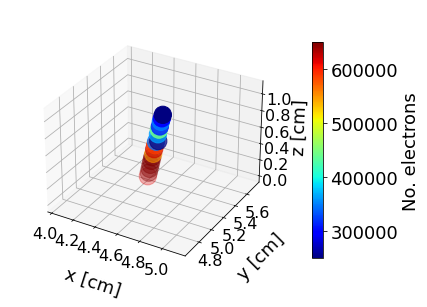

In [10]:
# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# Look at a single event after the cut
test_event = tracks.iloc[11]
# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, Mult_factor = 1.0, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
dsp.Reconst3D_v0()
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma,save_name = "sim_alpha")

# Assess point resolution versus absolute z

In [14]:
def get_PR(tracks, mu = -6.7, sigma = 16.4 , n_sigma = 3, G_x = 9.0, G_y = 4.5, n_strips_x = 500, n_strips_y=500, pitch_x=200, pitch_y=200, theta_min = theta_min, theta_max = theta_max):

    # Analyze point resolution
    all_z = np.array([])
    all_c = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])



    for index, row in tracks.iterrows():

        try:
            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = row, Mult_factor = 1.0, gain_x=G_x, gain_y=G_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, v_drift=8.0, pitch_x=pitch_x, pitch_y=pitch_y) # Mult factor always 1 for sim
            
            # Remove delayed hits (as discussed in the slides)
            dsp.mask_channels(masked_x_channels=[296,306,307,326],masked_y_channels=None)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            
            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_c = np.append(all_c,c)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Get mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c, start = 0.0, stop = 1.2, step = 0.2,plot=False)



    plt.figure()
    plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

    return np.abs(x_sigmas2), x_sigmas_err2, np.abs(y_sigmas2), y_sigmas_err2, abs_z

sigma x:  42.62861798783938 +/- 1.8535048433650565
sigma y:  38.28513562887755 +/- 1.4553762343494052
sigma x:  39.139203315528064 +/- 1.6868588652440981
sigma y:  38.45844226732959 +/- 1.6148711846854273
sigma x:  -39.15577878440143 +/- 1.780973770328347
sigma y:  38.92128127919004 +/- 1.710074408554221
sigma x:  39.073936082029824 +/- 1.6848295011324275
sigma y:  -42.400418688178576 +/- 2.262628979458355
sigma x:  44.43526971700322 +/- 2.225537484183964
sigma y:  -46.151821701991544 +/- 2.5711278597896903
sigma x:  44.88181724036012 +/- 2.957946949051878
sigma y:  47.838423087130415 +/- 2.8421033018756363


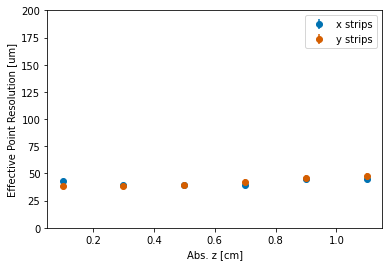

In [15]:
# Example point res calc
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks)

# Simulate Po210 in UH DLC Quadrant a



In [23]:
# Make dataframe to store all results

df_resolution = pd.DataFrame(columns = ['Name','x_res', 'x_res_err', 'y_res', 'y_res_err','abs_z'])

sigma x:  38.16907789152161 +/- 0.596621645797058
sigma y:  40.03207045457232 +/- 0.5890397191653336
sigma x:  34.35866102947176 +/- 0.6226449953320682
sigma y:  38.97780874418523 +/- 0.7442200766452106
sigma x:  36.66147693907917 +/- 0.702233587559465
sigma y:  41.80498045216339 +/- 0.9209546207764125
sigma x:  -37.46346433557406 +/- 0.7955543591233918
sigma y:  43.752674409297065 +/- 1.0994954528842933
sigma x:  39.731823187165084 +/- 0.918185173958558
sigma y:  43.93639591709092 +/- 1.1479541587880284
sigma x:  46.57568892989593 +/- 1.2029179847430205
sigma y:  47.4173432806781 +/- 1.2356010656137342


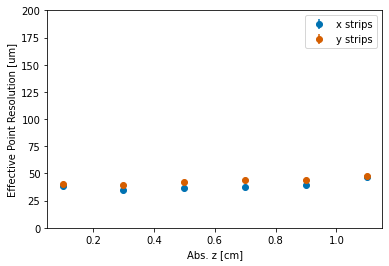

In [24]:
Charge_sharing = 0.41
Gain = 604
pitch_x = 200               # in um
pitch_y = 200               # in um
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 9.0     # in mV/fC
electronic_gain_y = 4.5     # in mV/fC

# 3D clustering paramters
mu = T_off.iloc[0]["Mu"]
sigma = T_off.iloc[0]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)


# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max)


df_resolution = df_resolution.append({'Name' : "UH_DLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UH NoDLC Quadrant a

sigma x:  44.92006751046693 +/- 0.6181425149706512
sigma y:  45.72106170084714 +/- 0.653874914711745
sigma x:  40.629844330262685 +/- 0.6056898502327592
sigma y:  43.8433801744892 +/- 0.6728088058685272
sigma x:  41.23929139114361 +/- 0.6325361037834276
sigma y:  44.57186871630396 +/- 0.7130157232651839
sigma x:  43.919816315791095 +/- 0.7272545529035441
sigma y:  47.223824700974724 +/- 0.8669969487504499
sigma x:  45.644480915255855 +/- 0.8230518089828588
sigma y:  47.77310127633668 +/- 0.9068776307698436
sigma x:  54.955704235049 +/- 1.27325262204512
sigma y:  56.31653478322018 +/- 1.2935659108931423


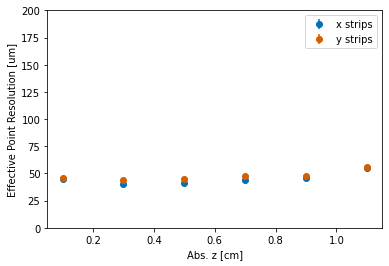

In [25]:
Charge_sharing = 0.62
Gain = 604
pitch_x = 200
pitch_y = 200
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 9.0
electronic_gain_y = 4.5


# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )

df_resolution = df_resolution.append({'Name' : "UH_NoDLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UoS

sigma x:  32.43984400412825 +/- 0.716486134909024
sigma y:  39.23799765685965 +/- 0.8910149691024238
sigma x:  36.143156445889176 +/- 0.8753530885048227
sigma y:  37.96034718180943 +/- 1.17475272162833
sigma x:  36.05190514640259 +/- 0.9743487875977213
sigma y:  36.57106103215219 +/- 1.1173860178214867
sigma x:  35.11940124550261 +/- 1.0639809607852246
sigma y:  35.58095858851828 +/- 1.132212307877281
sigma x:  -37.615392423991175 +/- 1.7276298109073458
sigma y:  39.14282290159849 +/- 2.934471124120949
sigma x:  41.2528516264082 +/- 4.925917409871804
sigma y:  52.76073080448534 +/- 8.17982582811648


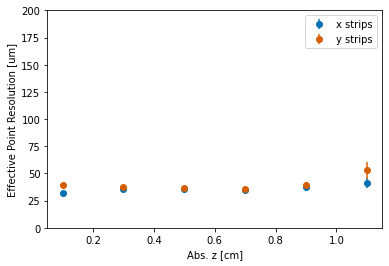

In [26]:
Charge_sharing = 0.13
Gain = 5351
pitch_x = 250
pitch_y = 250
n_strips_x = 358
n_strips_y = 358
electronic_gain_x 
electronic_gain_x= 1.0
electronic_gain_y = 1.0

# 3D clustering paramters
mu = T_off.iloc[8]["Mu"]
sigma = T_off.iloc[8]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/electronic_gain_x*6241.5, thres_y =  82/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )

df_resolution = df_resolution.append({'Name' : "UoS", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



In [27]:
df_resolution.to_pickle("./data/resolution_sim.pk")
df_resolution

,Name,x_res,x_res_err,y_res,y_res_err,abs_z
0,UH_DLC_a,"[38.16907789152161, 34.35866102947176, 36.6614...","[0.596621645797058, 0.6226449953320682, 0.7022...","[40.03207045457232, 38.97780874418523, 41.8049...","[0.5890397191653336, 0.7442200766452106, 0.920...","[0.1, 0.3, 0.5, 0.7, 0.9, 1.1]"
1,UH_NoDLC_a,"[44.92006751046693, 40.629844330262685, 41.239...","[0.6181425149706512, 0.6056898502327592, 0.632...","[45.72106170084714, 43.8433801744892, 44.57186...","[0.653874914711745, 0.6728088058685272, 0.7130...","[0.1, 0.3, 0.5, 0.7, 0.9, 1.1]"
2,UoS,"[32.43984400412825, 36.143156445889176, 36.051...","[0.716486134909024, 0.8753530885048227, 0.9743...","[39.23799765685965, 37.96034718180943, 36.5710...","[0.8910149691024238, 1.17475272162833, 1.11738...","[0.1, 0.3, 0.5, 0.7, 0.9, 1.1]"


# Appendix: No threshold, larger drift length

In [86]:
def get_PR_w_expected(tracks, mu = -6.7, sigma = 16.4 , n_sigma = 3, DL=5.0, G_x = 9.0, G_y = 4.5, n_strips_x = 500, n_strips_y=500, pitch_x=200, pitch_y=200, theta_min = theta_min, theta_max = theta_max,DTrans = 0.0135):

    # Analyze point resolution
    all_z = np.array([])
    all_c = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])



    for index, row in tracks.iterrows():

        try:
            # Make a TrackTools object for the event
            dsp = stripROtools.TrackTools(event = row, Mult_factor = 1.0, gain_x=G_x, gain_y=G_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, v_drift=8.0, pitch_x=pitch_x, pitch_y=pitch_y) # Mult factor always 1 for sim
            
            # Remove delayed hits (as discussed in the slides)
            dsp.prune_track(T_L = 0, T_H=250)
            dsp.prune_track2(gap=2)

            x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma, plot = False)

            
            # Only consider tracks with 5 or more points 
            if len(x) > 5:

                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = stripROtools.GetTransErrs( x,y,z,c, charge_weighting = True)
                
                # Angle to vertical
                ang_z = np.arccos(v_PA[2])*57.2958

                if (ang_z>theta_min) and (ang_z<theta_max):
            
                    all_z = np.append(all_z,z_vals)
                    all_c = np.append(all_c,c)
                    all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                    all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                    all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                    all_y_err_2 = np.append(all_y_err_2,delta_ys_2)
                

            
        except:
            pass

    # Switch to cm
    all_z = all_z*1E-4

    # Get mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = stripROtools.Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c,   start = 0.0, stop = DL, step = 0.2, plot=False)



    plt.figure()
    plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    plt.plot(abs_z, np.sqrt( ( 200/np.sqrt(12) )**2 +(np.sqrt(abs_z)*DTrans*10000)**2), color=colors["black"] )
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,300))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

    return np.abs(x_sigmas2), x_sigmas_err2, np.abs(y_sigmas2), y_sigmas_err2, abs_z

sigma x:  74.48609658736322 +/- 0.0008503946859072356
sigma y:  69.67126674824011 +/- 0.0008129676657337408
sigma x:  49.58367064462472 +/- 0.000697405297484459
sigma y:  146240.39881783904 +/- 53685914.56096944
sigma x:  45.48953314293422 +/- 0.0006586811738646529
sigma y:  44.1602593889423 +/- 0.0006005574119456944
sigma x:  -45.44025684452416 +/- 0.000681331589398921
sigma y:  -47.85360597206628 +/- 0.0007293284776158086
sigma x:  48.73064385510409 +/- 0.0007990882723003691
sigma y:  48.78524773668668 +/- 0.0008103729507237313
sigma x:  48.370037013532205 +/- 0.0007601564226646854
sigma y:  48.78051855003325 +/- 0.0007533478807628947
sigma x:  52.006585644426586 +/- 0.0008733086489101078
sigma y:  53.52344814733437 +/- 0.0009058635221817295
sigma x:  53.78266359080945 +/- 0.0009589163358621449
sigma y:  52.79472684848303 +/- 0.0008564216676084465
sigma x:  56.13285328841642 +/- 0.0010262748960375456
sigma y:  57.34459041922069 +/- 0.001008508770099605
sigma x:  58.605854783311614 +/

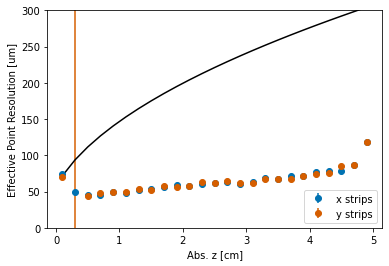

In [95]:
Charge_sharing = 1
Gain = 1000
pitch_x = 200
pitch_y = 200
n_strips_x = 500
n_strips_y = 500
electronic_gain_x = 4.5
electronic_gain_y = 4.5
drift_length = 5.0


# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# simulatue tracks
tracks = sim_p210(n_sims = 500, DL = drift_length, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 400, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 0.0/electronic_gain_x*6241.5, thres_y =  0.0/electronic_gain_y*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, DL=drift_length, pitch_z = 0.02, G_x = electronic_gain_x, G_y = electronic_gain_x)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR_w_expected(tracks, mu = mu, sigma = sigma , n_sigma = n_sigma, DL =drift_length, G_x = electronic_gain_x, G_y = electronic_gain_y, n_strips_x = n_strips_x, n_strips_y=n_strips_y, pitch_x=pitch_x, pitch_y=pitch_y, theta_min = theta_min, theta_max = theta_max )




[  10.42539392   51.49829572  176.4855467   273.32450531  365.91800857
  463.77346299  549.51035271  685.11783628  781.41792035  864.44614646
 1025.04730321 1112.05815804 1243.91959886 1352.66660275 1468.88006667
 1546.33769813 1677.1629394  1774.27526841 1876.15629394 2026.44984941
 2143.93341981 2245.69259074 2356.48723098 2487.16114031 2606.45711518
 2674.61951313 2789.46632796 2911.54179492 3098.36956265 3187.83364679
 3168.79831953 3290.59439084 3398.42334607 3644.65704455 3811.48018777
 3833.76143881 4042.32118324 4048.88423034 4169.15144455 4240.11197575
 4463.56502077 4415.47739255 4603.87533076 4602.52436206 4920.84986924
 4941.91011554 4940.80953448 5261.96640122 5453.28202742 5329.57828747
 5606.1747454  5543.16056018 5878.11780875 5976.39833092 6067.26705324
 5954.63183667]


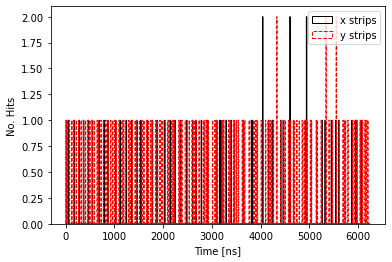

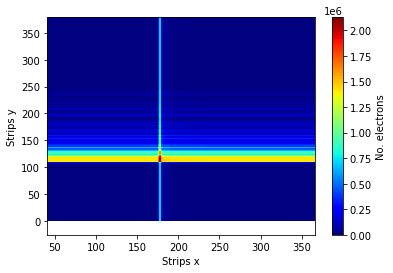

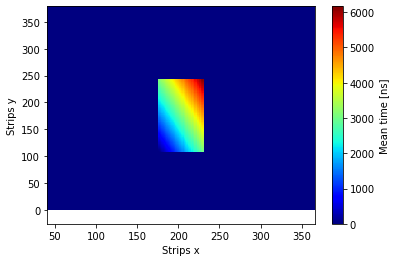

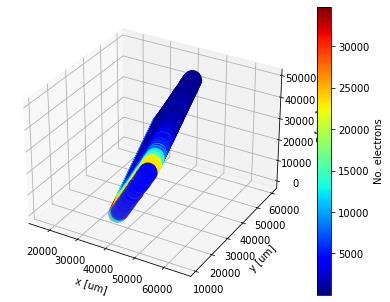

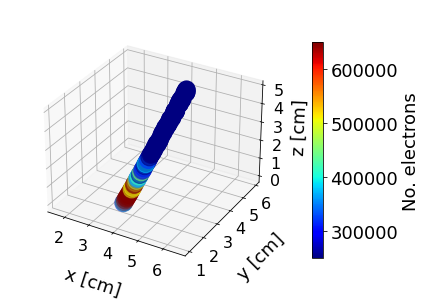

In [89]:
# 3D clustering paramters
mu = T_off.iloc[4]["Mu"]
sigma = T_off.iloc[4]["Sigma"]
n_sigma = 3

# Look at a single event after the cut
test_event = tracks.iloc[3]
# Make a TrackTools object for the event
dsp = stripROtools.TrackTools(event = test_event, Mult_factor = 1.0, gain_x=9, gain_y=4.5, v_drift=8.0)

# Plot 1D time display
dsp.TimeHistView( t_bin =10)

# Plot 2D displays of charge and time
dsp.Strip2DView(fullview = False)
dsp.Strip2DView_times(fullview = False)

# Plot 3D displays
dsp.Reconst3D_v0()
x,y,z,c = dsp.Reconst3D_v1( mu = mu, sigma = sigma , n_sigma = n_sigma,save_name = "sim_alpha")